# Algo trading strategy for ETH-USDT pair

## Importing python modules and data

In [355]:
import yfinance as yf 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import mplfinance as mpf
import datetime
import os
import sys
import time
import numpy as np


### Importing data

In [356]:
eth = yf.download('ETH-USD', start='2021-01-01', end='2023-12-31', interval='1d')
eth.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

[*********************100%%**********************]  1 of 1 completed


## Defining the Class for the strategy and running it

### Defining the strategy class

In [357]:
class strategy:
    def __init__(self, dataframe):
        self.df = dataframe

### Adding HeikenAshi candles calculating function

In [358]:
#Calculating the Heiken Ashi candles


def calculate_heiken_ashi_candles(self):
    self.df['HA_Close'] = (self.df['Open'] + self.df['High'] + self.df['Low'] + self.df['Close']) / 4
    self.df['HA_Open'] = (self.df['Open'].shift(1) + self.df['Close'].shift(1)) / 2
    self.df['HA_High'] = self.df[['High', 'HA_Open', 'HA_Close']].max(axis=1)
    self.df['HA_Low'] = self.df[['Low', 'HA_Open', 'HA_Close']].min(axis=1)

strategy.calculate_heiken_ashi_candles = calculate_heiken_ashi_candles

### Adding ATR calculating function

In [359]:
def calculate_atr(self, period=14):
    high_low = self.df['High'] - self.df['Low']
    high_close = abs(self.df['High'] - self.df['Close'].shift(1))
    low_close = abs(self.df['Low'] - self.df['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(period).mean()
    self.df['ATR'] = atr
    return self.df

strategy.calculate_atr = calculate_atr

### Adding Keltner Channel calculating function

In [360]:
def calculate_keltner_channels(self, period=20, multiplier=2.5):
    self.df['KC_Middle'] = self.df['Close'].rolling(period).mean()
    self.df['KC_Upper'] = self.df['KC_Middle'] + multiplier * self.df['Close'].rolling(period).std()
    self.df['KC_Lower'] = self.df['KC_Middle'] - multiplier * self.df['Close'].rolling(period).std()
    return self.df

strategy.calculate_keltner_channels = calculate_keltner_channels

### Backtesting strat function to find optimal settings

In [361]:
def backtest(self, take_profit_atr, stop_loss_atr, transaction_cost = 0.001):
    eth = self.df.copy()    # Use a copy of main dataframe
    eth.dropna(inplace=True)   # remove rows with Null values

    eth['capital'] = None 
    eth.at[eth.index[0], 'capital'] = 1000
    eth['position'] = None 
    eth.at[eth.index[0], 'position'] = 0


    stop_loss = 0
    trades = 0
    take_profit = 0

    for i in range(1, len(eth)):
        if eth.iloc[i-1]['position'] == 0:
            if (eth.iloc[i]['Close'] > eth.iloc[i]['KC_Upper']) and (eth.iloc[i-1]['Close'] < eth.iloc[i-1]['KC_Upper']) and (eth.iloc[i]['HA_Close'] > eth.iloc[i]['HA_Open']) and (eth.iloc[i-1]['HA_Close'] > eth.iloc[i-1]['HA_Open']):
                eth.at[eth.index[i], 'position'] = (eth.iloc[i-1]['capital'] / (1+transaction_cost))/ eth.iloc[i]['Close']
                eth.at[eth.index[i], 'capital'] = 0
                stop_loss = eth.iloc[i]['Close'] -  stop_loss_atr * eth.iloc[i]['ATR']
                take_profit = eth.iloc[i]['Close'] +  take_profit_atr * eth.iloc[i]['ATR']
                trades +=1
            else:
                eth.at[eth.index[i], 'capital'] = eth.iloc[i-1]['capital']
                eth.at[eth.index[i], 'position'] = eth.iloc[i-1]['position']
        else:
            if (eth.iloc[i]['Low']< stop_loss) and eth.iloc[i-1]['position'] > 0:
                eth.at[eth.index[i], 'capital'] = ((eth.iloc[i-1]['position'] * stop_loss)/ (1+transaction_cost))
                eth.at[eth.index[i], 'position'] = 0
            elif (eth.iloc[i]['High']> take_profit) and eth.iloc[i-1]['position'] > 0:
                eth.at[eth.index[i], 'capital'] = ((eth.iloc[i-1]['position'] * take_profit)/ (1+transaction_cost))
                eth.at[eth.index[i], 'position'] = 0
            else:
                eth.at[eth.index[i], 'capital'] = eth.iloc[i-1]['capital']
                eth.at[eth.index[i], 'position'] = eth.iloc[i-1]['position']
    eth['portfolio_value'] = eth['capital'] + eth['Close'] * eth['position']        
    return eth.iloc[-1]['portfolio_value']

strategy.backtest = backtest




### Find the Optimal Settings

In [362]:
strat = strategy(eth)
strat.calculate_heiken_ashi_candles()
strat.calculate_atr()

best_result = 0
keltner_multiplier = 0
best_set_atr = 0
best_stop_atr = 0

for i in range(2,5):
    strat.calculate_keltner_channels(multiplier=(i/2))
    returns = []
    for j in range(5, 15):
        set_atr = j/2
        for k in range(2, 6):
            stop_atr = k/2
            returns.append([strat.backtest(set_atr, stop_atr), set_atr, stop_atr])
    best = max(returns)
    print(f"The maximum portfolio value at end for {i/2} atr wide keltner channel is {best[0]} at set_atr {best[1]} and stop_atr {best[2]}")
    if best[0] > best_result:
        best_result = best[0]
        keltner_multiplier = i/2
        best_set_atr = best[1]
        best_stop_atr = best[2]


The maximum portfolio value at end for 1.0 atr wide keltner channel is 6301.318868261309 at set_atr 6.5 and stop_atr 1.5
The maximum portfolio value at end for 1.5 atr wide keltner channel is 3998.1342707814097 at set_atr 5.5 and stop_atr 1.5
The maximum portfolio value at end for 2.0 atr wide keltner channel is 3315.176637824353 at set_atr 3.5 and stop_atr 2.0


### Add the function to calculate all the important things with optimal values

In [363]:
def backtest_with_details(self, take_profit_atr, stop_loss_atr, transaction_cost = 0.001):  # The function to run in the end with optimal values
    eth = self.df.copy()    # Use a copy of main dataframe
    eth.dropna(inplace=True)   # remove rows with Null values

    eth['capital'] = None 
    eth.at[eth.index[0], 'capital'] = 1000
    eth['position'] = None 
    eth.at[eth.index[0], 'position'] = 0


    stop_loss = 0
    take_profit = 0
    open_price = 0
    days_open = 0


    winning_trades = []
    losing_trades = []
    gross_profit = 0

    holding_duration = []
    charges = 0

    for i in range(1, len(eth)):
        if eth.iloc[i-1]['position'] == 0:
            if (eth.iloc[i]['Close'] > eth.iloc[i]['KC_Upper']) and (eth.iloc[i-1]['Close'] < eth.iloc[i-1]['KC_Upper']) and (eth.iloc[i]['HA_Close'] > eth.iloc[i]['HA_Open']) and (eth.iloc[i-1]['HA_Close'] > eth.iloc[i-1]['HA_Open']):
                eth.at[eth.index[i], 'position'] = (eth.iloc[i-1]['capital'] / (1+transaction_cost))/ eth.iloc[i]['Close']  # Buy only as much as you can pay transaction cost for
                charges += eth.iloc[i]['Close'] * eth.at[eth.index[i], 'position'] * transaction_cost                       # add up the charges
                open_price = eth.iloc[i]['Close']                                                                           # set the open price for the trade
                eth.at[eth.index[i], 'capital'] = 0                                                                         # set the capital to 0
                stop_loss = eth.iloc[i]['Close'] -  stop_loss_atr * eth.iloc[i]['ATR']                                      # set the stop loss
                take_profit = eth.iloc[i]['Close'] +  take_profit_atr * eth.iloc[i]['ATR']                                  # set the take profit   
                days_open = 0                                                                                               # set the days trade has been open for to 0
            else:
                eth.at[eth.index[i], 'capital'] = eth.iloc[i-1]['capital']
                eth.at[eth.index[i], 'position'] = eth.iloc[i-1]['position']
                days_open += 1


        else:
            if (eth.iloc[i]['Low']< stop_loss) and eth.iloc[i-1]['position'] > 0:
                freed_capital = eth.iloc[i-1]['position'] * stop_loss
                eth.at[eth.index[i], 'capital'] =  freed_capital * (1-transaction_cost)                                      # sell at stop loss price and pay transaction cost from received capital
                eth.at[eth.index[i], 'position'] = 0                                                                         # set position to 0
                losing_trades.append((-eth.iloc[i]['Close'] + open_price) / open_price * 100)                                # append the loss as a percentage of the open price to losing trades list
                gross_profit += eth.iloc[i]['capital'] - (open_price*eth.iloc[i-1]['position'])                                                            # add the loss to gross profit
                holding_duration.append(days_open+1)                                                                          # append the days trade was open for
                charges += freed_capital * transaction_cost                                                                  # add the transaction cost to charges


            elif (eth.iloc[i]['High']> take_profit) and eth.iloc[i-1]['position'] > 0:
                freed_capital = eth.iloc[i-1]['position'] * take_profit
                eth.at[eth.index[i], 'capital'] = freed_capital * (1-transaction_cost)                                       # sell at take profit price and pay transaction cost from received capital
                eth.at[eth.index[i], 'position'] = 0                                                                         # set position to 0
                winning_trades.append((eth.iloc[i]['Close'] - open_price) / open_price * 100)                                # append the profit as a percentage of the open price to winning trades list
                gross_profit += eth.iloc[i]['capital'] - (open_price*eth.iloc[i-1]['position'])                                                        # add the profit to gross profit
                holding_duration.append(days_open+1)                                                                         # append the days trade was open for
                charges += freed_capital * transaction_cost                                                                  # add the transaction cost to charges

            else:
                eth.at[eth.index[i], 'capital'] = eth.iloc[i-1]['capital']
                eth.at[eth.index[i], 'position'] = eth.iloc[i-1]['position']
                days_open += 1

    if eth.iloc[-1]['position'] > 0:
        eth.at[eth.index[-1], 'capital'] = eth.iloc[-1]['position'] * eth.iloc[-1]['Close'] * (1-transaction_cost)         # sell at last closing price and pay transaction cost from received capital
        eth.at[eth.index[-1], 'position'] = 0                                                                             # set position to 0
        if eth.iloc[-1]['Close']> open_price:
            winning_trades.append((eth.iloc[-1]['Close'] - open_price) / open_price * 100)                                    # append the profit as a percentage of the open price to winning trades list
        else:
            losing_trades.append((-eth.iloc[-1]['Close'] + open_price) / open_price * 100)                                    # append the profit as a percentage of the open price to losing trades list
        gross_profit += eth.iloc[i]['capital'] - (open_price*eth.iloc[i-1]['position'])                                                                 # add the profit to gross profit
        holding_duration.append(days_open+1)                                                                             # append the days trade was open for
        charges += eth.iloc[-1]['position'] * eth.iloc[-1]['Close'] * transaction_cost                                   # add the transaction cost to charges
    eth['portfolio_value'] = eth['capital'] + eth['Close'] * eth['position']     
    return winning_trades, losing_trades, gross_profit, holding_duration, charges, eth

strategy.backtest_with_details = backtest_with_details

## Stats

In [369]:
strat.calculate_keltner_channels(multiplier=keltner_multiplier)
winning_trades, losing_trades, gross_profit, holding_duration, charges, result = strat.backtest_with_details(best_set_atr, best_stop_atr)

print(f"Total trades: {len(winning_trades) + len(losing_trades)}")
print(f"Win Rate: {round(len(winning_trades)/(len(winning_trades)+len(losing_trades)), 2)*100}%")
print(f"Average winning trade: {round(np.mean(winning_trades), 2)}%")
print(f"Average losing trade: {round(np.mean(losing_trades), 2)}%")
print(f"Average holding duration: {round(np.mean(holding_duration), 2)} days")
print(f"Charges: {round(charges, 2)}")
print(f"Gross profit: {round(gross_profit,2)}")
print(f"Net profit: {round(gross_profit - charges, 2)}")

# Calculate daily returns
returns = result['portfolio_value'].pct_change()

# Calculate annualized return
annualized_return = np.mean(returns) * 365

# Calculate annualized volatility
annualized_volatility = np.std(returns) * np.sqrt(365)

# Calculate Sharpe Ratio
sharpe_ratio = annualized_return / annualized_volatility

print(f"Sharpe Ratio: {round(sharpe_ratio, 2)}")

portfolio_value = result['portfolio_value']
peak = portfolio_value.cummax()
drawdown = (portfolio_value - peak) / peak
max_drawdown = drawdown.min()

print(f"Maximum Drawdown: {round(-max_drawdown*100, 2)}%")

negative_returns = returns[returns < 0]
downside_deviation = np.std(negative_returns)

sortino_ratio = (annualized_return - 0) / (downside_deviation * np.sqrt(365))

print(f"Sortino Ratio: {round(sortino_ratio, 2)}")




Total trades: 21
Win Rate: 48.0%
Average winning trade: 32.31%
Average losing trade: 6.98%
Average holding duration: 20.76 days
Charges: 164.34
Gross profit: 5377.48
Net profit: 5213.14
Sharpe Ratio: 1.6
Maximum Drawdown: 30.36%
Sortino Ratio: 1.7


## Visualization 

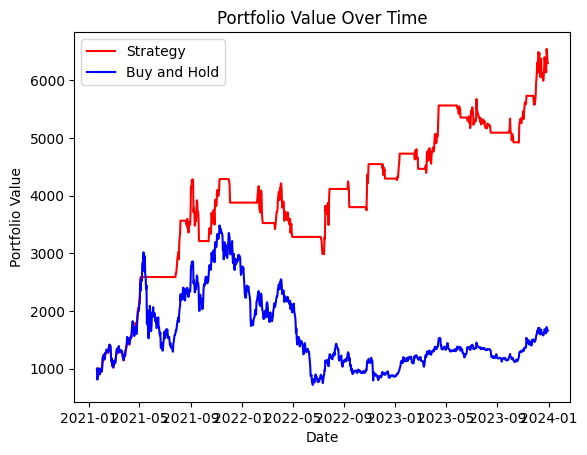

In [365]:
plt.plot(result.index, result['portfolio_value'], color='red', label="Strategy")
plt.plot(result.index, result['Close']*1000/result['Close'].iloc[0], color='blue', label="Buy and Hold")
plt.legend(loc="upper left")
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.show()